In [1]:
import importlib
import sys
import torch
import pickle
import os
import pandas as pd

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

### Spread analysis:

here we analyse the connection between the input (i.e. prefix) and the output (i.e. sampled predictions)

For the input we measure:
1. How many times was the prefix present in the data set (How common is the prefix?)
2. How long is the prefix?

For the ouput we measure:
1. What was the spread different metrics:
    - (only activity) dominance index
    - (only activity) shannon entropy
    - (only activity) effective catgegories
    - (only activity) brier score
-> TODO add temporal component to the ouput spread metrics
-> TODO Mine a net and use a net-based distance measure to measure pairwise distance

Findings:

In [2]:
#load model
file_path_model = '../../notebooks/training_variational_dropout/Helpdesk/Helpdesk_full_grad_norm_philipp_4layer.pkl'
model = DropoutUncertaintyEncoderDecoderLSTM.load(file_path_model, dropout=0.0)

# Load the dataset
file_path_data_set = '../../../encoded_data/test_philipp//helpdesk_all_5_test.pkl'

helpdesk_test_dataset = torch.load(file_path_data_set, weights_only=False)

Data set categories:  ([('Activity', 16, {'Assign seriousness': 1, 'Closed': 2, 'Create SW anomaly': 3, 'DUPLICATE': 4, 'EOS': 5, 'INVALID': 6, 'Insert ticket': 7, 'RESOLVED': 8, 'Require upgrade': 9, 'Resolve SW anomaly': 10, 'Resolve ticket': 11, 'Schedule intervention': 12, 'Take in charge ticket': 13, 'VERIFIED': 14, 'Wait': 15}), ('Resource', 24, {'EOS': 1, 'Value 1': 2, 'Value 10': 3, 'Value 11': 4, 'Value 12': 5, 'Value 13': 6, 'Value 14': 7, 'Value 15': 8, 'Value 16': 9, 'Value 17': 10, 'Value 18': 11, 'Value 19': 12, 'Value 2': 13, 'Value 20': 14, 'Value 21': 15, 'Value 22': 16, 'Value 3': 17, 'Value 4': 18, 'Value 5': 19, 'Value 6': 20, 'Value 7': 21, 'Value 8': 22, 'Value 9': 23}), ('Variant index', 175, {'1.0': 1, '10.0': 2, '100.0': 3, '103.0': 4, '104.0': 5, '107.0': 6, '109.0': 7, '11.0': 8, '110.0': 9, '112.0': 10, '113.0': 11, '114.0': 12, '115.0': 13, '117.0': 14, '118.0': 15, '12.0': 16, '120.0': 17, '122.0': 18, '123.0': 19, '124.0': 20, '125.0': 21, '126.0': 22, '1

In [3]:

import evaluation.probabilistic_evaluation
importlib.reload(evaluation.probabilistic_evaluation)
from evaluation.probabilistic_evaluation import ProbabilisticEvaluation

new_eval = ProbabilisticEvaluation(model=model, 
                                   dataset=helpdesk_test_dataset,
                                   concept_name='Activity',
                                   num_processes=16,
                                   #growing_num_values = [],
                                   growing_num_values = ['case_elapsed_time'],
                                   samples_per_case = 1,
                                   sample_argmax = False,
                                   use_variance_cat = True,
                                   use_variance_num = True,
                                   all_cat=['Activity', 'Resource'],
                                   all_num=['case_elapsed_time', 'event_elapsed_time'])


In [4]:
import pandas as pd
import pickle

output_dir = '../../../../../../../evaluation_results/Helpdesk'

# We'll collect the results row-wise for DataFrame construction
results_rows = []
for i, (case_name, prefix_len, prefix, predicted_suffixes, suffix, mean_prediction) in enumerate(new_eval.evaluate_multi_processing(random_order=True)):
    row = {
        'case_name': case_name,
        'prefix_len': prefix_len,
        'prefix': prefix,
        'suffix': suffix,
        'mean_prediction': mean_prediction,
        'predicted_suffixes': predicted_suffixes
    }
    results_rows.append(row)

# Create DataFrame
results_df = pd.DataFrame(results_rows)

with open ("results_store_helpdesk_results.pkl", "wb") as f:
    pickle.dump(results_df,f)


  0%|          | 0/916 [00:00<?, ?it/s]

In [5]:
import pickle

with open("results_store_helpdesk_results.pkl", "rb") as f:
    results_df = pickle.load(f)

results_df = pd.DataFrame(results_df)



In [6]:
import math
from collections import Counter

'''

def category_proportions(row):

    """Return proportions of each category in the list."""
    stringified_values = []

    for value in row["predicted_suffixes"]:
        stringified_values.append(str(value))

    counts = Counter(stringified_values)
    total = len(stringified_values)
    return {cat: count / total for cat, count in counts.items()}

def dominance_index(values):
    """
    Dominance Index = proportion of the most common category.
    Higher means more dominance (less spread).
    """
    props = category_proportions(values)
    return max(props.values())

def shannon_entropy(values, base=math.e):
    """
    Shannon entropy of a categorical distribution.
    base = math.e gives natural log; use base=2 for bits.
    """
    props = category_proportions(values)
    return -sum(p * math.log(p, base) for p in props.values())

def effective_number_of_categories(values, base=math.e):
    """
    Effective Number of Categories (ENC) = exp(entropy).
    Measures how many categories are effectively present.
    """
    H = shannon_entropy(values, base=base)
    return base ** H

    '''

'\n\ndef category_proportions(row):\n\n    """Return proportions of each category in the list."""\n    stringified_values = []\n\n    for value in row["predicted_suffixes"]:\n        stringified_values.append(str(value))\n\n    counts = Counter(stringified_values)\n    total = len(stringified_values)\n    return {cat: count / total for cat, count in counts.items()}\n\ndef dominance_index(values):\n    """\n    Dominance Index = proportion of the most common category.\n    Higher means more dominance (less spread).\n    """\n    props = category_proportions(values)\n    return max(props.values())\n\ndef shannon_entropy(values, base=math.e):\n    """\n    Shannon entropy of a categorical distribution.\n    base = math.e gives natural log; use base=2 for bits.\n    """\n    props = category_proportions(values)\n    return -sum(p * math.log(p, base) for p in props.values())\n\ndef effective_number_of_categories(values, base=math.e):\n    """\n    Effective Number of Categories (ENC) = exp(

In [7]:
import matplotlib.pyplot as plt

from classes.event import Event, HelpdeskEvent
from classes.sequence import Sequence
from classes.suffix_samples import SuffixSamples


In [8]:
from classes.prefix_counter import PrefixCounter

dataset = pd.read_csv("../../../data/helpdesk.csv")

prefix_counter = PrefixCounter(dataset=dataset)

def count_prefix_occurences_from_row(row, counter):
    suffix_samples = SuffixSamples.from_row(row)
    prefix = suffix_samples.prefix
    occurences = counter.count_prefix_occurences(prefix.event_list)
    return occurences


In [9]:
scoring_measure_cols = ["avg_activity_score", "avg_length_score", "avg_temp_score"]
results_df[scoring_measure_cols] = results_df.apply(
    lambda row: pd.Series(SuffixSamples.get_scoring_measure(row)),
    axis=1
)

In [10]:
results_df["shannon_entropy_activities"] = results_df.apply(SuffixSamples.calculate_shannon_entropy_on_activity_suffix, axis=1)
results_df["brier_score_activities"] = results_df.apply(SuffixSamples.calculate_brier_score_full_suffix, axis=1)
results_df["prefix_occurences_in_dataset"] = results_df.apply(
    lambda row: count_prefix_occurences_from_row(row, prefix_counter),
    axis=1
)

In [11]:
results_df.head()

,case_name,prefix_len,prefix,suffix,mean_prediction,predicted_suffixes,avg_activity_score,avg_length_score,avg_temp_score,shannon_entropy_activities,brier_score_activities,prefix_occurences_in_dataset
0,Case 3927,1,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Take in charge ticket', 'Resour...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",2.0,1.0,16.879352,-0.0,1.0,4384
1,Case 3927,2,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",0.0,0.0,9.466691,-0.0,0.0,3706
2,Case 3927,3,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Closed', 'Resource': 'Value 5',...","[{'Activity': 'Closed', 'Resource': 'Value 5',...","[[{'Activity': 'Closed', 'Resource': 'Value 5'...",0.0,0.0,23.189994,-0.0,0.0,2571
3,Case 439,1,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Take in charge ticket', 'Resour...","[{'Activity': 'Take in charge ticket', 'Resour...","[[{'Activity': 'Take in charge ticket', 'Resou...",0.0,0.0,3.602381,-0.0,0.0,4384
4,Case 439,2,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",0.0,0.0,10.441726,-0.0,0.0,3706


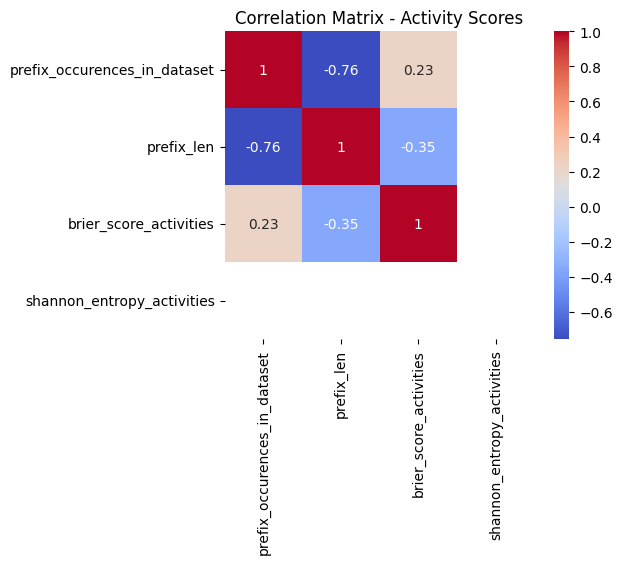

In [12]:
import seaborn as sns

corr = results_df[["prefix_occurences_in_dataset","prefix_len","brier_score_activities","shannon_entropy_activities"]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    cbar=True,
)
plt.title("Correlation Matrix - Activity Scores")
plt.show()


### Key Takeaways

1. Long Prefixes are less likely to occure often in the dataset
2. Brier Score (True suffix closeness) and Shannon Entropy (Prediction spread) correlate highly

3. Medium correlation between prefix length and the scores
4. Low - medium correlation between data set occurences and scores (But possibly second order effects of prefix length <> occurences correlation)

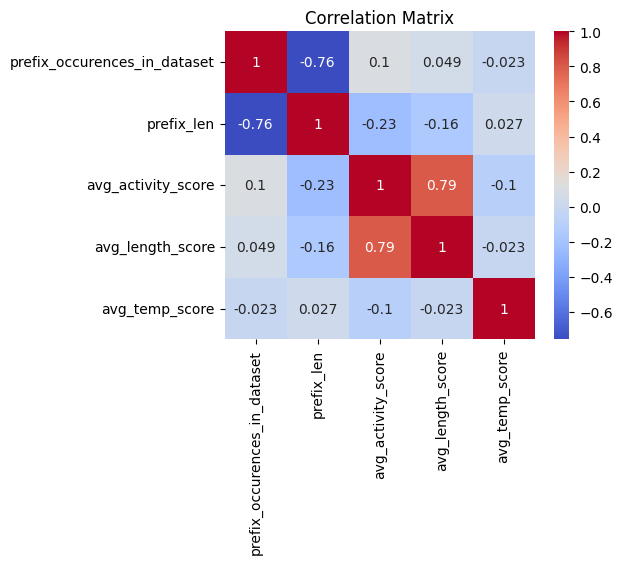

In [13]:


corr = results_df[[
    "prefix_occurences_in_dataset",
    "prefix_len",
    "avg_activity_score",
    "avg_length_score",
    "avg_temp_score",
]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    cbar=True,
)
plt.title("Correlation Matrix")
plt.show()


## What we have done, what we are doing next:

1. We first measured the certainty and spread of the models predictions using:
    a. shannon entropy (spread)
    b. brier score (certainty)
2. We found that the certainity/spread have a strong negative correlation with the prefix length (ca. -0.59)
3. We calculated the number of occurences of a given prefix in the data set
    - We did not distinguish between train/test/evaluate data sets, as they are sampled randomly and assuming the data set is large enough this should still represent the training set
4. we found, that these also correlate with certainity/spread, but less much so (0.2-0.4)
5. But they do correlate strongly (negatively) with prefix length (-0.76)
6. Now to find out, if the number of occurences in the data set only correlate with the output, because 

In [14]:
from classes.suffix_samples import SuffixSamples

# Get the top 5 and bottom 5 rows of brier_score
top5_bs = results_df.nlargest(5, "brier_score_activities")
bottom5_bs = results_df.nsmallest(5, "brier_score_activities")

print("Top 5 Brier Score Rows as SuffixSamples:")
for idx, row in top5_bs.iterrows():
    suffix_sample = SuffixSamples.from_row(row)
    print(f"Index: {idx}")
    print(suffix_sample)
    print("-" * 40)

print("\nBottom 5 Brier Score Rows as SuffixSamples:")
for idx, row in bottom5_bs.iterrows():
    suffix_sample = SuffixSamples.from_row(row)
    print(f"Index: {idx}")
    print(suffix_sample)
    print("-" * 40)


Top 5 Brier Score Rows as SuffixSamples:
Index: 0
SuffixSamples(case_name=Case 3927, prefix=Sequence(len=1, events=[
  Assign seriousness - 11 days, 3:35:03.312500
]), suffix=Sequence(len=3, events=[
  Take in charge ticket - 5:04:23.021826
  Resolve ticket - 0:00:41.996843
  Closed - 43 days, 18:57:49.076463
]), mean_prediction=Sequence(len=2, events=[
  Resolve ticket - 4 days, 13:08:15.231851
  Closed - 14 days, 17:47:50.931835
]), suffix_len=3, num_predicted_suffixes=1)
----------------------------------------
Index: 5
SuffixSamples(case_name=Case 1491, prefix=Sequence(len=4, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 0:01:27.960685
  None - 0:00:30.022295
  Take in charge ticket - 39 days, 18:04:50.099901
]), suffix=Sequence(len=2, events=[
  Resolve ticket - 0:08:03.949778
  Closed - 15 days, 0:00:19.998035
]), mean_prediction=Sequence(len=2, events=[
  Resolve ticket - 8 days, 4:54:49.484785
  Closed - 15 days, 21:10:17.386330
]), suffix_le

### Key Takeaways:

1. High uncertainty (Brier score) are those with long predicted prefixes
2. Low uncertainty are those where you just predict one activity (i.e. closed)
3. The model tends to predict "Closed" multiple times - which makes little sense (looking into it more later)

## Next: Introducing more nuanced scoring methods for the activity sequence

Levenshtein distance instead of looking at the activity sequence as a whole (as in brier/shannon)

In the literature [(Tax et. al. 2017)](https://arxiv.org/pdf/1612.02130) often the Damerau-Levenstein 
distance is used, but the advantage of having a "switching" operation does not necessarily make sense for helpdesk tasks.
Because they have pretty strict and inherent order.

In [15]:

def apply_mean_lev_dist(row):
    ss = SuffixSamples.from_row(row)
    x = ss.get_avg_leventshtein_dist_to_predicted_suffix()
    return x

def apply_act_lev_dist(row):
    ss = SuffixSamples.from_row(row)
    x = ss.get_avg_leventshtein_dist_to_actual_suffix()
    return x


results_df["avg_lev_dist_mean"] = results_df.apply(apply_mean_lev_dist, axis=1)

results_df["avg_lev_dist_actual"]  = results_df.apply(apply_act_lev_dist, axis=1)



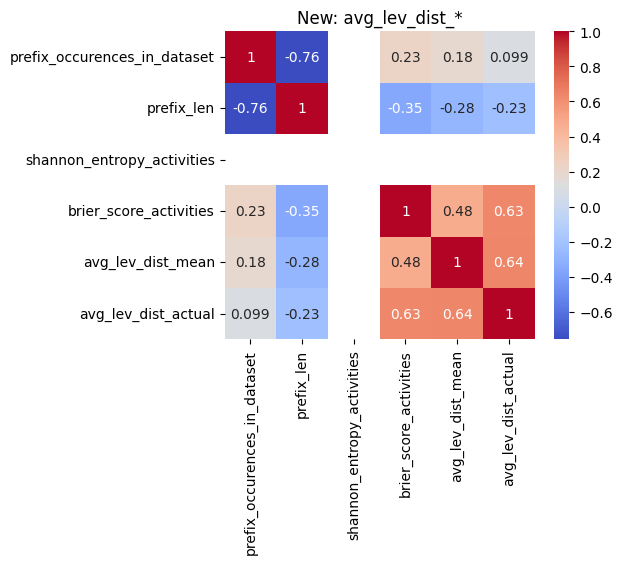

In [16]:
corr = results_df[[
    "prefix_occurences_in_dataset",
    "prefix_len",
    "shannon_entropy_activities",
    "brier_score_activities",
    "avg_lev_dist_mean",
    "avg_lev_dist_actual"
]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    cbar=True,
)
plt.title("New: avg_lev_dist_*")
plt.show()

**Takeaway:** Correlates strongly with other scores, little new insight.

In [17]:
def get_suffix_length(row):
    ss = SuffixSamples.from_row(row)
    return len(ss.suffix.event_list)

results_df["actual_suffix_length"]  = results_df.apply(get_suffix_length, axis=1)


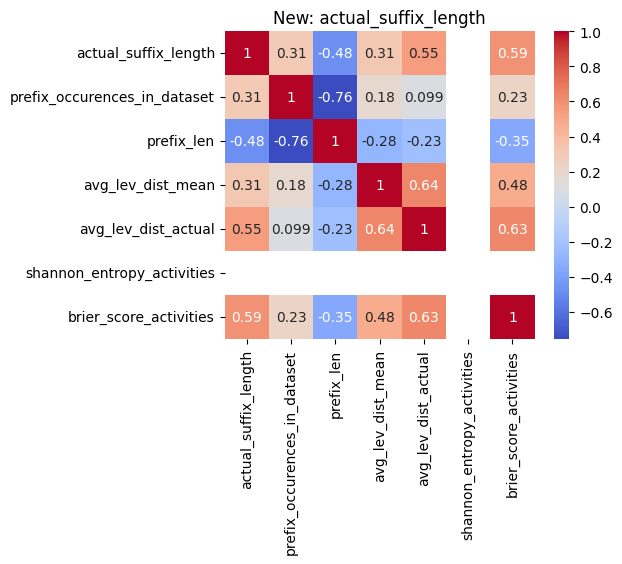

In [18]:
corr = results_df[[
    "actual_suffix_length",
    "prefix_occurences_in_dataset",
    "prefix_len",
    "avg_lev_dist_mean",
    "avg_lev_dist_actual",
    "shannon_entropy_activities",
    "brier_score_activities"
]].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    cbar=True,
)
plt.title("New: actual_suffix_length")
plt.show()

**Takeaway**: Very high correlation to the scores. "Long suffix means, high uncertainty".


Then: Let's compare predictions with the same true suffix length to get a view past that.

Thererfore we break the samples down by "actual_suffix_length" and order them by a score + see the top and bottom performers.

In [19]:

import pandas as pd
from classes.suffix_samples import SuffixSamples

grouped = results_df.groupby('actual_suffix_length')
for actual_suffix_length, group in grouped:
    n_rows = group.shape[0]
    if n_rows < 1:
        continue  # nothing to show

    sorted_group = group.sort_values("avg_lev_dist_actual", ascending=True)
    top5 = sorted_group.tail(5)
    bottom5 = sorted_group.head(5)

    print(f"\nactual_suffix_length = {actual_suffix_length} (n = {n_rows})")

    print("\nTop 5 (highest avg_lev_dist_actual):")
    for idx, row in top5.sort_values("avg_lev_dist_mean", ascending=False).iterrows():
        ss = SuffixSamples.from_row(row)
        mean_dist = row['avg_lev_dist_mean']
        actual_dist = row['avg_lev_dist_actual']
        print(f"\nCase: {row['case_name']}, avg_lev_dist_mean: {mean_dist:.3f}, avg_lev_dist_actual: {actual_dist:.3f}")
        print("SuffixSamples object:")
        print(ss)
    
    print("\nBottom 5 (lowest avg_lev_dist_actual):")
    for idx, row in bottom5.iterrows():
        ss = SuffixSamples.from_row(row)
        mean_dist = row['avg_lev_dist_mean']
        actual_dist = row['avg_lev_dist_actual']
        print(f"\nCase: {row['case_name']}, avg_lev_dist_mean: {mean_dist:.3f}, avg_lev_dist_actual: {actual_dist:.3f}")
        print("SuffixSamples object:")
        print(ss)






actual_suffix_length = 1 (n = 916)

Top 5 (highest avg_lev_dist_actual):

Case: Case 236, avg_lev_dist_mean: 7.000, avg_lev_dist_actual: 7.000
SuffixSamples object:
SuffixSamples(case_name=Case 236, prefix=Sequence(len=3, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 16 days, 6:24:51.016940
  Resolve ticket - 2 days, 18:14:58.955609
]), suffix=Sequence(len=1, events=[
  Closed - 15 days, 0:00:12.997530
]), mean_prediction=Sequence(len=1, events=[
  Closed - 19 days, 1:27:14.072066
]), suffix_len=1, num_predicted_suffixes=1)

Case: Case 2057, avg_lev_dist_mean: 5.000, avg_lev_dist_actual: 5.000
SuffixSamples object:
SuffixSamples(case_name=Case 2057, prefix=Sequence(len=3, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 26 days, 0:33:19.995102
  Resolve ticket - 0:00:19.982097
]), suffix=Sequence(len=1, events=[
  Closed - 30 days, 0:00:26.047302
]), mean_prediction=Sequence(len=1, events=[
  Closed - 18 days, 20:47:

Takeaway:

When you remove the suffix length from the equation: It gets miuch harder to find clear patterns.

However:
- We again observe weirdness in the "mean_prediction" e.g. multiple "Resolve ticket" and "Closed" activities

But:
- No clear langauge in terms of how shorter/longer prefixes make for clearer predictions. 
But we want to double check that with more quantitative measures

With prefix length = 1, the mean avg_lev_dist_mean is 1.824 (n=916)
With prefix length = 2, the mean avg_lev_dist_mean is 1.322 (n=916)
With prefix length = 3, the mean avg_lev_dist_mean is 0.696 (n=878)
With prefix length = 4, the mean avg_lev_dist_mean is 0.664 (n=357)
With prefix length = 5, the mean avg_lev_dist_mean is 0.493 (n=148)
With prefix length = 6, the mean avg_lev_dist_mean is 0.409 (n=66)
With prefix length = 7, the mean avg_lev_dist_mean is 0.483 (n=29)
With prefix length = 8, the mean avg_lev_dist_mean is 0.750 (n=12)
With prefix length = 9, the mean avg_lev_dist_mean is 0.250 (n=4)
With prefix length = 10, the mean avg_lev_dist_mean is 2.000 (n=2)
With prefix length = 11, the mean avg_lev_dist_mean is 2.000 (n=1)


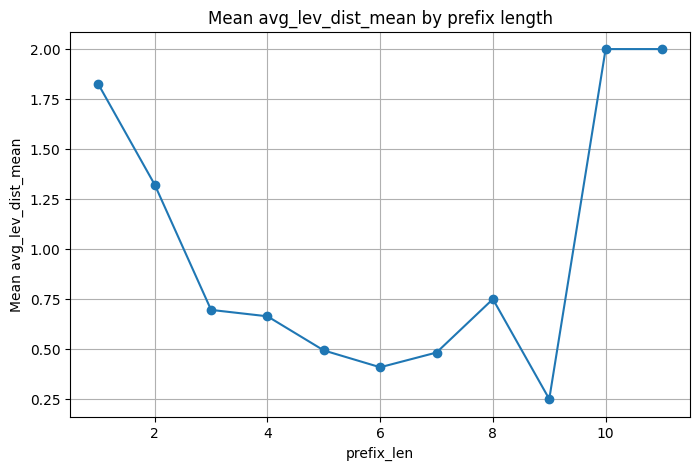

In [20]:
import matplotlib.pyplot as plt

# For each prefix_len, print the mean avg_lev_dist_mean

for prefix_len, group in results_df.groupby('prefix_len'):
    mean_lev_dist = group['avg_lev_dist_mean'].mean()
    n_cases = len(group)
    print(f"With prefix length = {prefix_len}, the mean avg_lev_dist_mean is {mean_lev_dist:.3f} (n={n_cases})")

# Optionally, visualize if still needed (remove if just textual output is desired):

plt.figure(figsize=(8, 5))
means = results_df.groupby('prefix_len')['avg_lev_dist_mean'].mean()
plt.plot(means.index, means.values, marker='o')
plt.xlabel("prefix_len")
plt.ylabel("Mean avg_lev_dist_mean")
plt.title("Mean avg_lev_dist_mean by prefix length")
plt.grid()
plt.show()

With actual_suffix_length = 1, the mean avg_lev_dist_mean is 0.206 (n=916)
With actual_suffix_length = 2, the mean avg_lev_dist_mean is 1.211 (n=916)
With actual_suffix_length = 3, the mean avg_lev_dist_mean is 1.731 (n=878)
With actual_suffix_length = 4, the mean avg_lev_dist_mean is 1.669 (n=357)
With actual_suffix_length = 5, the mean avg_lev_dist_mean is 1.709 (n=148)
With actual_suffix_length = 6, the mean avg_lev_dist_mean is 1.758 (n=66)
With actual_suffix_length = 7, the mean avg_lev_dist_mean is 1.897 (n=29)
With actual_suffix_length = 8, the mean avg_lev_dist_mean is 1.333 (n=12)
With actual_suffix_length = 9, the mean avg_lev_dist_mean is 1.000 (n=4)
With actual_suffix_length = 10, the mean avg_lev_dist_mean is 0.500 (n=2)
With actual_suffix_length = 11, the mean avg_lev_dist_mean is 1.000 (n=1)


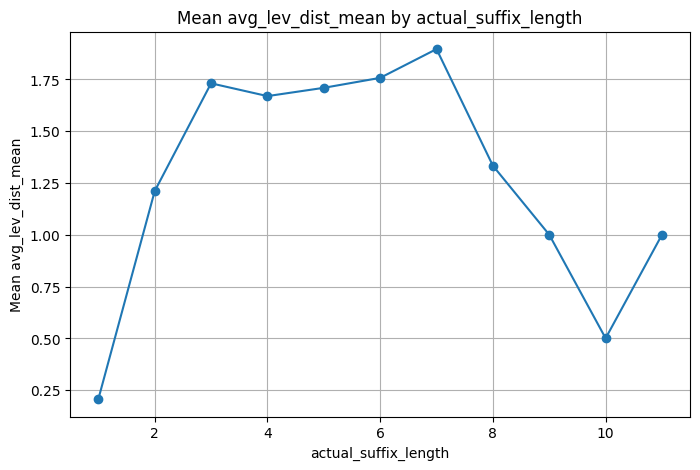

In [21]:
# For each actual_suffix_length, print the mean avg_lev_dist_mean

for suffix_len, group in results_df.groupby('actual_suffix_length'):
    mean_lev_dist = group['avg_lev_dist_mean'].mean()
    n_cases = len(group)
    print(f"With actual_suffix_length = {suffix_len}, the mean avg_lev_dist_mean is {mean_lev_dist:.3f} (n={n_cases})")

# Optionally, visualize if still needed (remove if just textual output is desired):

plt.figure(figsize=(8, 5))
means = results_df.groupby('actual_suffix_length')['avg_lev_dist_mean'].mean()
plt.plot(means.index, means.values, marker='o')
plt.xlabel("actual_suffix_length")
plt.ylabel("Mean avg_lev_dist_mean")
plt.title("Mean avg_lev_dist_mean by actual_suffix_length")
plt.grid()
plt.show()




This is a very telling graph:

When predicting the final event i.e. "Closed", the model is very certain.
For predicting the final 2 events (incl. "Resolve ticket"), it is still quite certain.

However for the other activities, it the uncertainty is much higher, but constant.

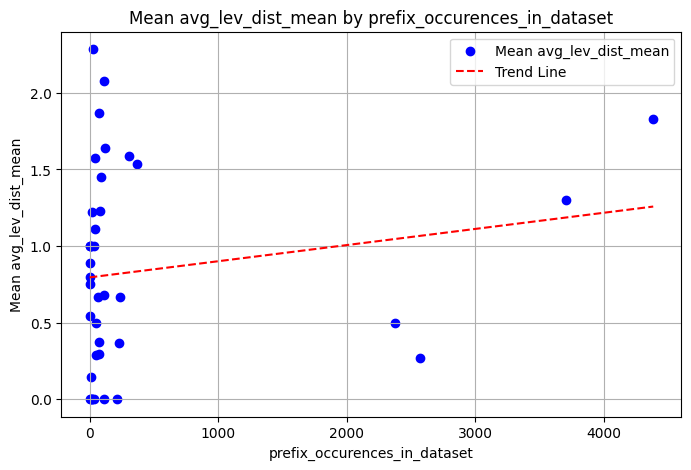

In [22]:
import numpy as np

plt.figure(figsize=(8, 5))
means = results_df.groupby('prefix_occurences_in_dataset')['avg_lev_dist_mean'].mean()
plt.scatter(means.index, means.values, color='blue', label='Mean avg_lev_dist_mean')
# Add trend line (linear fit)
z = np.polyfit(means.index, means.values, 1)
p = np.poly1d(z)
plt.plot(means.index, p(means.index), color='red', linestyle='--', label='Trend Line')
plt.xlabel("prefix_occurences_in_dataset")
plt.ylabel("Mean avg_lev_dist_mean")
plt.title("Mean avg_lev_dist_mean by prefix_occurences_in_dataset")
plt.grid()
plt.legend()
plt.show()


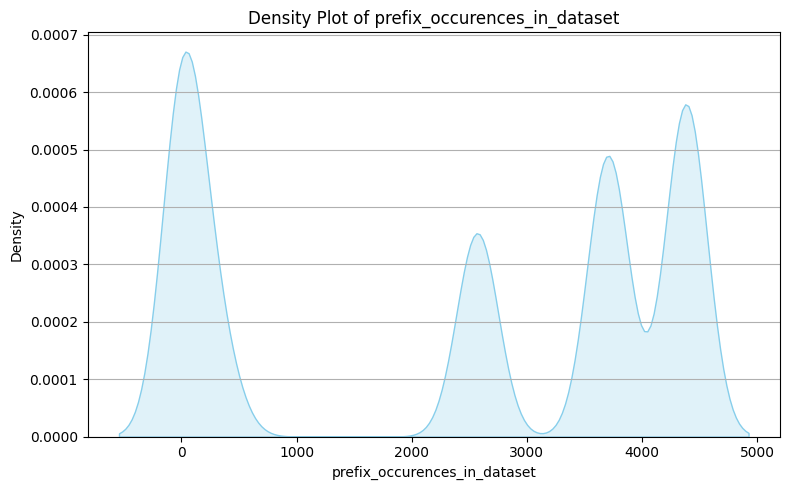


Top 5 most common prefixes and their counts in the dataset:

Prefix #Sequence(len=1, events=[
  Assign seriousness - 11 days, 3:35:03.312500
]) (Count: 872):

Prefix #Sequence(len=2, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 5:04:23.021826
]) (Count: 737):

Prefix #Sequence(len=4, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 0:01:27.960685
  None - 0:00:30.022295
  Take in charge ticket - 39 days, 18:04:50.099901
]) (Count: 637):

Prefix #Sequence(len=3, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Take in charge ticket - 5:04:23.021826
  Resolve ticket - 0:00:41.996843
]) (Count: 533):

Prefix #Sequence(len=2, events=[
  Assign seriousness - 11 days, 3:35:03.312500
  Assign seriousness - 0:00:22.008559
]) (Count: 78):


In [23]:
import seaborn as sns

# Create a KDE (density) plot for prefix_occurences_in_dataset
plt.figure(figsize=(8, 5))
sns.kdeplot(results_df['prefix_occurences_in_dataset'], fill=True, color='skyblue', bw_adjust=0.5)
plt.xlabel("prefix_occurences_in_dataset")
plt.ylabel("Density")
plt.title("Density Plot of prefix_occurences_in_dataset")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Print out the first 'top_n' unique prefixes (as event sequences) that appear most frequently in the dataset,
# using SuffixSamples.from_row() to decode the prefix data
top_n = 5  # Number of top prefixes to print

# Group by 'prefix_occurences_in_dataset' to get frequency
prefix_counts = results_df.groupby('prefix_occurences_in_dataset').size().sort_values(ascending=False)

print(f"\nTop {top_n} most common prefixes and their counts in the dataset:")
for idx, (prefix_occur_val, count) in enumerate(prefix_counts.head(top_n).items(), 1):
    # Find one example row for this occurrence value
    example_row = results_df[results_df['prefix_occurences_in_dataset'] == prefix_occur_val].iloc[0]
    suffix_sample = SuffixSamples.from_row(example_row)
    prefix_seq = suffix_sample.prefix
    # You can pretty-print the events or just print the list
    print(f"\nPrefix #{prefix_seq} (Count: {count}):")


In [24]:
from src.aa_philipp.classes.suffix_samples import SuffixSamples

def count_closed_in_sequence(seq):
    return sum(1 for event in seq.event_list if event.activity == "Closed")

def count_resolve_ticket_in_sequence(seq):
    return sum(1 for event in seq.event_list if event.activity == "Resolve ticket")

def get_avg_closed_and_resolve_in_samples(samples):
    closed_counts = []
    resolve_counts = []
    for predicted_seq in samples.predicted_suffixes:
        closed_counts.append(count_closed_in_sequence(predicted_seq))
        resolve_counts.append(count_resolve_ticket_in_sequence(predicted_seq))
    avg_closed = sum(closed_counts) / len(closed_counts) if closed_counts else 0
    avg_resolve = sum(resolve_counts) / len(resolve_counts) if resolve_counts else 0
    return avg_closed, avg_resolve

def count_closed_and_resolve(row):
    samples = SuffixSamples.from_row(row) 

    closed_in_mean_pred = count_closed_in_sequence(samples.mean_prediction)
    closed_in_actual = count_closed_in_sequence(samples.suffix)

    resolve_in_mean_pred = count_resolve_ticket_in_sequence(samples.mean_prediction)
    resolve_in_actual = count_resolve_ticket_in_sequence(samples.suffix)

    avg_closed_samples, avg_resolve_samples = get_avg_closed_and_resolve_in_samples(samples)

    return pd.Series({
        'closed_count_mean_prediction': closed_in_mean_pred,
        'closed_count_actual_suffix': closed_in_actual,
        'resolve_ticket_count_mean_prediction': resolve_in_mean_pred,
        'resolve_ticket_count_actual_suffix': resolve_in_actual,
        'avg_closed_count_predicted_suffix_samples': avg_closed_samples,
        'avg_resolve_ticket_count_predicted_suffix_samples': avg_resolve_samples
    })

results_df[
    [
        "closed_count_mean_prediction", 
        "closed_count_actual_suffix", 
        "resolve_ticket_count_mean_prediction", 
        "resolve_ticket_count_actual_suffix",
        "avg_closed_count_predicted_suffix_samples",
        "avg_resolve_ticket_count_predicted_suffix_samples"
    ]
] = results_df.apply(lambda row: count_closed_and_resolve(row), axis=1)



In [25]:
percent = lambda cond: 100 * cond.sum() / len(results_df)

pct_closed_mean_pred = percent(results_df["closed_count_mean_prediction"] > 1)
print(f"Percentage of times closed_count_mean_prediction is more than one: {pct_closed_mean_pred:.2f}%")

pct_closed_actual = percent(results_df["closed_count_actual_suffix"] > 1)
print(f"Percentage of times more than one 'Closed' event is in the actual suffix: {pct_closed_actual:.2f}%")

pct_resolve_mean_pred = percent(results_df["resolve_ticket_count_mean_prediction"] > 1)
print(f"Percentage of times more than one 'Resolve' event is in the mean prediction suffix: {pct_resolve_mean_pred:.2f}%")

pct_resolve_actual = percent(results_df["resolve_ticket_count_actual_suffix"] > 1)
print(f"Percentage of times more than one 'Resolve' event is in the actual suffix: {pct_resolve_actual:.2f}%")


percentiles_closed = results_df["avg_closed_count_predicted_suffix_samples"].quantile([0.1, 0.5, 0.9])
print("Range where 80% of avg_closed_count_predicted_suffix_samples fall (between 10th and 90th percentile):")
print(f"  10th percentile: {percentiles_closed.loc[0.1]}")
print(f"  50th percentile (median): {percentiles_closed.loc[0.5]}")
print(f"  90th percentile: {percentiles_closed.loc[0.9]}")

percentiles_resolve = results_df["avg_resolve_ticket_count_predicted_suffix_samples"].quantile([0.1, 0.5, 0.9])
print("Range where 80% of avg_resolve_ticket_count_predicted_suffix_samples fall (between 10th and 90th percentile):")
print(f"  10th percentile: {percentiles_resolve.loc[0.1]}")
print(f"  50th percentile (median): {percentiles_resolve.loc[0.5]}")
print(f"  90th percentile: {percentiles_resolve.loc[0.9]}")



results_df.head()

Percentage of times closed_count_mean_prediction is more than one: 0.66%
Percentage of times more than one 'Closed' event is in the actual suffix: 0.72%
Percentage of times more than one 'Resolve' event is in the mean prediction suffix: 4.30%
Percentage of times more than one 'Resolve' event is in the actual suffix: 4.72%
Range where 80% of avg_closed_count_predicted_suffix_samples fall (between 10th and 90th percentile):
  10th percentile: 1.0
  50th percentile (median): 1.0
  90th percentile: 2.0
Range where 80% of avg_resolve_ticket_count_predicted_suffix_samples fall (between 10th and 90th percentile):
  10th percentile: 0.0
  50th percentile (median): 1.0
  90th percentile: 2.0


,case_name,prefix_len,prefix,suffix,mean_prediction,predicted_suffixes,avg_activity_score,avg_length_score,avg_temp_score,shannon_entropy_activities,...,prefix_occurences_in_dataset,avg_lev_dist_mean,avg_lev_dist_actual,actual_suffix_length,closed_count_mean_prediction,closed_count_actual_suffix,resolve_ticket_count_mean_prediction,resolve_ticket_count_actual_suffix,avg_closed_count_predicted_suffix_samples,avg_resolve_ticket_count_predicted_suffix_samples
0,Case 3927,1,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Take in charge ticket', 'Resour...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",2.0,1.0,16.879352,-0.0,...,4384,0.0,2.0,3,1.0,1.0,1.0,1.0,1.0,1.0
1,Case 3927,2,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",0.0,0.0,9.466691,-0.0,...,3706,0.0,0.0,2,1.0,1.0,1.0,1.0,1.0,1.0
2,Case 3927,3,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Closed', 'Resource': 'Value 5',...","[{'Activity': 'Closed', 'Resource': 'Value 5',...","[[{'Activity': 'Closed', 'Resource': 'Value 5'...",0.0,0.0,23.189994,-0.0,...,2571,0.0,0.0,1,1.0,1.0,0.0,0.0,1.0,0.0
3,Case 439,1,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Take in charge ticket', 'Resour...","[{'Activity': 'Take in charge ticket', 'Resour...","[[{'Activity': 'Take in charge ticket', 'Resou...",0.0,0.0,3.602381,-0.0,...,4384,0.0,0.0,3,1.0,1.0,1.0,1.0,1.0,1.0
4,Case 439,2,"[{'Activity': 'Assign seriousness', 'Resource'...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[{'Activity': 'Resolve ticket', 'Resource': 'V...","[[{'Activity': 'Resolve ticket', 'Resource': '...",0.0,0.0,10.441726,-0.0,...,3706,0.0,0.0,2,1.0,1.0,1.0,1.0,1.0,1.0


## Off Topic

My thesis was: If the activity is incorrectly predicted, the event elapsed time cannot be very accurate

So in the following, I checked that. To make it easier, I only used the next event prediction (suffix at i=0)

In [26]:
from scipy.stats import ttest_ind

# first we only look at next event, i.e. the first item of prefix

# 1. we calculate if the first item of suffix mean prediction was correct

def calc_next_activity_correctness(row):
    suffix_sample = SuffixSamples.from_row(row)

    if len(suffix_sample.mean_prediction.event_list) == 0 or len(suffix_sample.suffix.event_list) == 0:
        return len(suffix_sample.mean_prediction.event_list) == len(suffix_sample.suffix.event_list)

    is_correct = suffix_sample.mean_prediction.event_list[0].activity == suffix_sample.suffix.event_list[0].activity
    return is_correct

results_df["next_activity_correctness"] = results_df.apply(calc_next_activity_correctness, axis=1)

# 2. we calculate the level of accuracy of the timestamp

def calc_next_activity_timeerror(row):
    suffix_sample = SuffixSamples.from_row(row)

    if len(suffix_sample.mean_prediction.event_list) == 0 and len(suffix_sample.suffix.event_list) == 0:
        return 0
    
    if len(suffix_sample.mean_prediction.event_list) == 0 or len(suffix_sample.suffix.event_list) == 0:
        return pd.NA

    delta = abs(suffix_sample.mean_prediction.event_list[0].event_elapsed_time - suffix_sample.suffix.event_list[0].event_elapsed_time)

    return delta

results_df["next_activity_timeerror"] = results_df.apply(calc_next_activity_timeerror, axis=1)


In [27]:

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

df = results_df.copy()

df["next_activity_correctness"] = df["next_activity_correctness"].astype(bool)
df["correctness_int"] = df["next_activity_correctness"].astype(int)

df["next_activity_timeerror"] = pd.to_numeric(df["next_activity_timeerror"], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["next_activity_timeerror", "correctness_int"])

correct_mask = df["next_activity_correctness"]
incorrect_mask = ~df["next_activity_correctness"]

correct_values = df.loc[correct_mask, "next_activity_timeerror"].astype(float).to_numpy()
incorrect_values = df.loc[incorrect_mask, "next_activity_timeerror"].astype(float).to_numpy()

print("Counts:", correct_values.size, incorrect_values.size)

# ---- A) P-value for correlation (point-biserial == Pearson with 0/1)

r, p_corr = pearsonr(df["next_activity_timeerror"].to_numpy(),
                     df["correctness_int"].to_numpy())
print(f"Correlation r = {r:.6f}, p = {p_corr:.6e}")

# ---- B) P-value for difference in means (Welch t-test)
t_stat, p_t = ttest_ind(correct_values, incorrect_values, equal_var=False)
print(f"Welch t-test: t = {t_stat:.6f}, p = {p_t:.6e}")

# ---- C) Non-parametric alternative (often better for skewed time deltas)
u_stat, p_u = mannwhitneyu(correct_values, incorrect_values, alternative="two-sided")
print(f"Mann–Whitney U: U = {u_stat:.6f}, p = {p_u:.6e}")


Counts: 2177 1145
Correlation r = 0.201255, p = 1.063028e-31
Welch t-test: t = 13.238271, p = 5.931289e-39
Mann–Whitney U: U = 1564702.000000, p = 8.499643e-34


### Positive correlation here means:

Higher activity prediction accuarcy correlates with lower time prediction accuracy. This seems counterintuitive.